In [10]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score 
import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


# MLFlow setup

In [11]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_Baseline_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Adjusted print model function

In [ ]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['date'] >= train_dates[0]) & (df_train['date'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['date'] >= test_dates[0]) & (df_test['date'] <= test_dates[1]) if test_dates else slice(None)

    

    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['date'] >= train_dates[0]) & (df_train_prediction['date'] <= train_dates[1])]
        #plt.plot(df_train_prediction['date'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['date'] >= test_dates[0]) & (df_test_prediction['date'] <= test_dates[1])]
        plt.plot(df_test_prediction['date'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='date', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('date').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['date'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['date'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))

    plt.plot(df_train.loc[train_mask, 'date'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'date'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.ylim(1.85, 2.10) # just for the presentation slides, change this back
    plt.show()
    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)
    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)
    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)
    
    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day
    


# Load Datasets

In [13]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

In [14]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

# Baseline Model

In [15]:
def baseline_model(data,date="datetime",value="e5",predictions=12*24,stepsize=(5,"minutes"),rule="daily mean"):
    """Predicts fuel prices with a simple model

    Args:
        data (DataFrame): Input dataset
        date (str, optional): Name of the datetime variable. Defaults to "datetime".
        value (str, optional): Name of the prediction variable. Defaults to "e5".
        predictions (int, optional): Number of predictions to make by the model. Defaults to 12*24.
        stepsize (tuple, optional): Time difference between predictions. Defaults to (5,"minutes").
        rule (str, optional): Rule for setting the prediction value. Can be "daily mean" (mean of previous day) or "last value" (last available value). Defaults to "daily mean".

    Returns:
        DataFrame: Prediction dataset
    """

    # Get first and last prediction dat
    if stepsize[1] == "minutes":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(minutes=(stepsize[0]*predictions)-1))
    elif stepsize[1] == "hours":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(hours=(stepsize[0]*predictions)-1))
    elif stepsize[1] == "days":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(days=(stepsize[0]*predictions)-1))

    # Get prediction value
    if rule == "last value":
        pred_value = data[value].iloc[-1]
    elif rule == "daily mean":
        pred_value = data[data[date]>= data[date].iloc[-1]-timedelta(days=1)][value].mean()
    

    # Create DataFrame with new predictions
    df_predict = pd.DataFrame(columns=[date,value])
    df_predict[date] = pd.date_range(start=first_date_predict, end=last_date_predict, freq=timedelta(minutes=stepsize[0]))
    df_predict[value] = pred_value

    return df_predict

# Fit Model


Processing dataset: df01
1-Day MAE in cent: 5.5186
1-Day RMSE in cent: 5.9800
1-Day r2-score: -5.7403
3-Day MAE in cent: 5.5473
3-Day RMSE in cent: 5.9799
3-Day r2-score: -6.0652
7-Day MAE in cent: 5.1605
7-Day RMSE in cent: 5.6816
7-Day r2-score: -4.0984


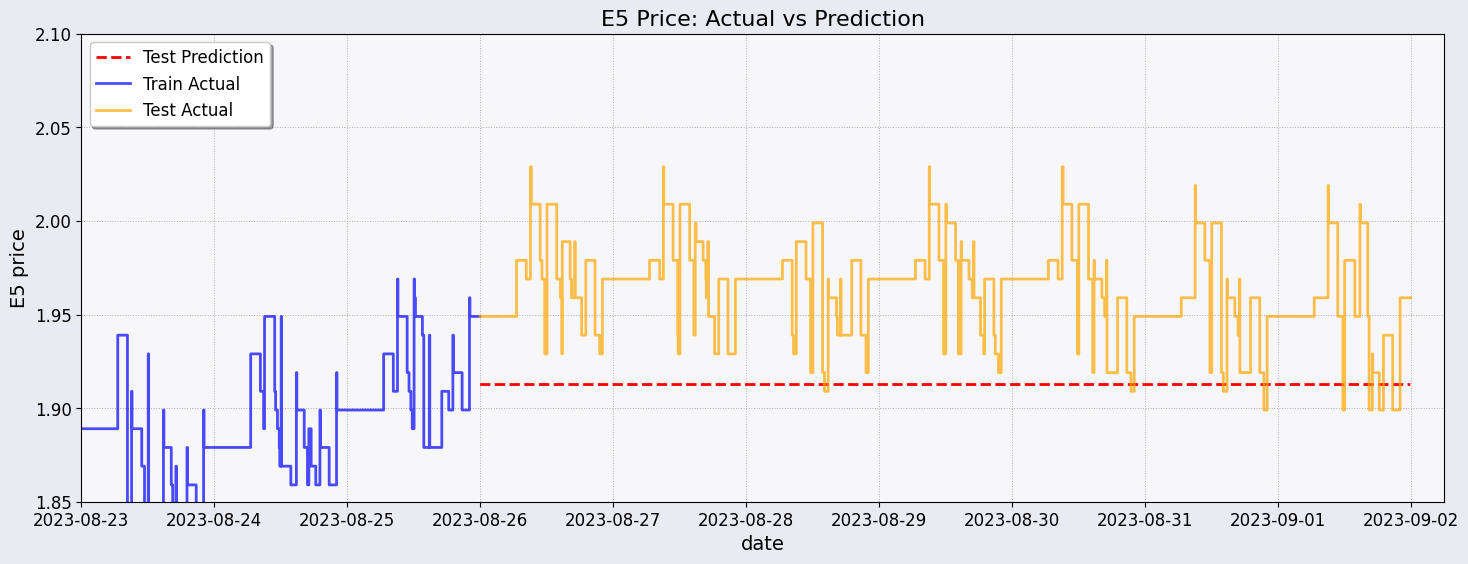

Successfully processed df01

Processing dataset: df02
1-Day MAE in cent: 2.2924
1-Day RMSE in cent: 3.0352
1-Day r2-score: -0.0730
3-Day MAE in cent: 2.3665
3-Day RMSE in cent: 3.1110
3-Day r2-score: -0.0375
7-Day MAE in cent: 2.5296
7-Day RMSE in cent: 3.2979
7-Day r2-score: -0.0190


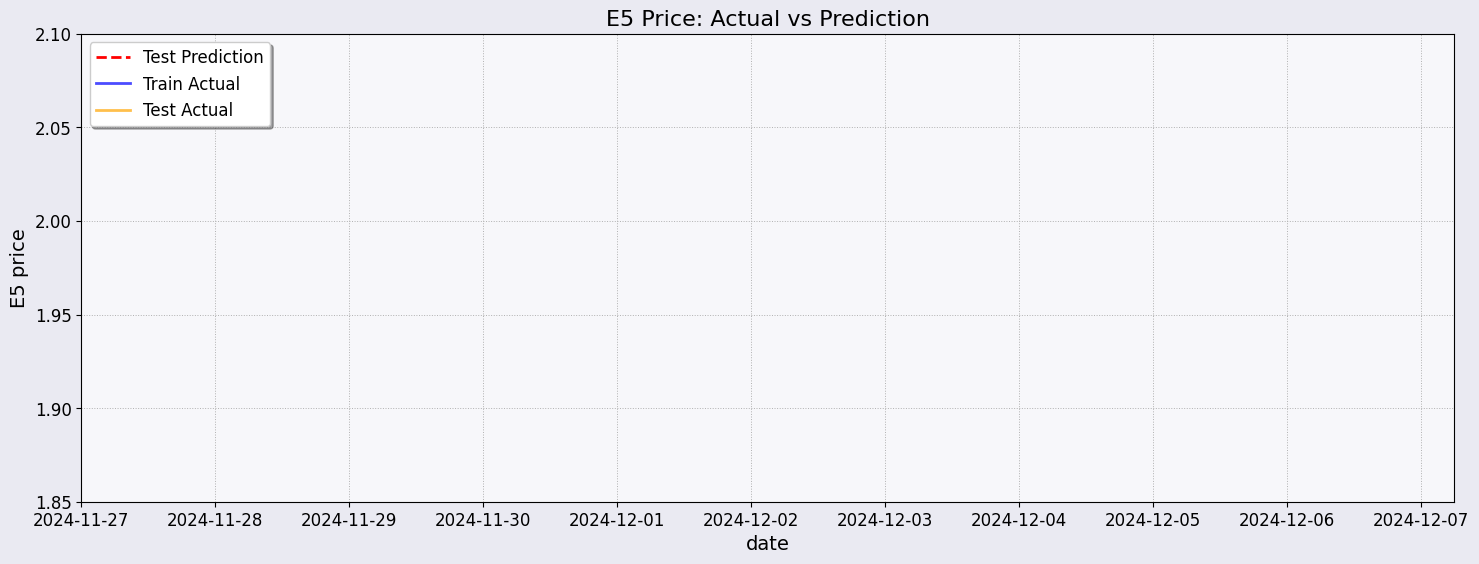

Successfully processed df02

Processing dataset: df03
1-Day MAE in cent: 2.1058
1-Day RMSE in cent: 3.1959
1-Day r2-score: -0.1404
3-Day MAE in cent: 2.2317
3-Day RMSE in cent: 3.2835
3-Day r2-score: -0.0371
7-Day MAE in cent: 2.9240
7-Day RMSE in cent: 3.9391
7-Day r2-score: -0.0699


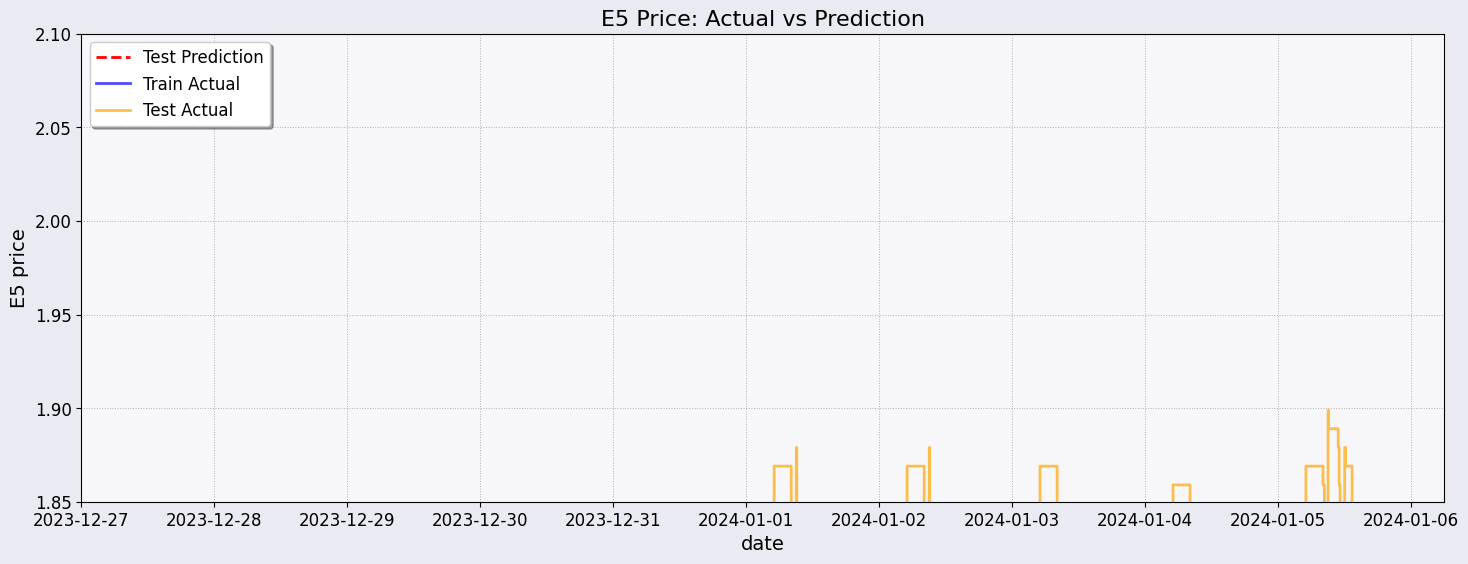

Successfully processed df03

Processing dataset: df04
1-Day MAE in cent: 2.0415
1-Day RMSE in cent: 2.7296
1-Day r2-score: -0.1675
3-Day MAE in cent: 2.1733
3-Day RMSE in cent: 2.8743
3-Day r2-score: -0.0380
7-Day MAE in cent: 2.3624
7-Day RMSE in cent: 3.2554
7-Day r2-score: -0.0992


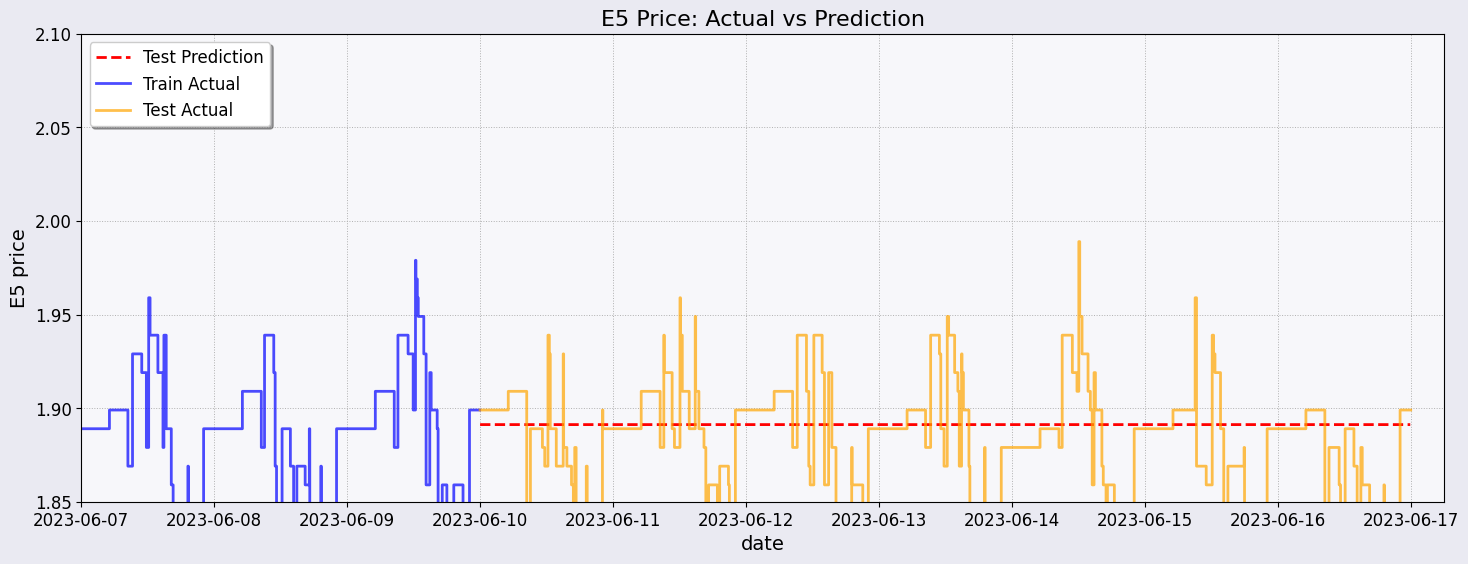

Successfully processed df04

Processing dataset: df05
1-Day MAE in cent: 2.7376
1-Day RMSE in cent: 3.2351
1-Day r2-score: -0.4247
3-Day MAE in cent: 4.1926
3-Day RMSE in cent: 4.7727
3-Day r2-score: -0.0297
7-Day MAE in cent: 3.5472
7-Day RMSE in cent: 4.0326
7-Day r2-score: -0.0157


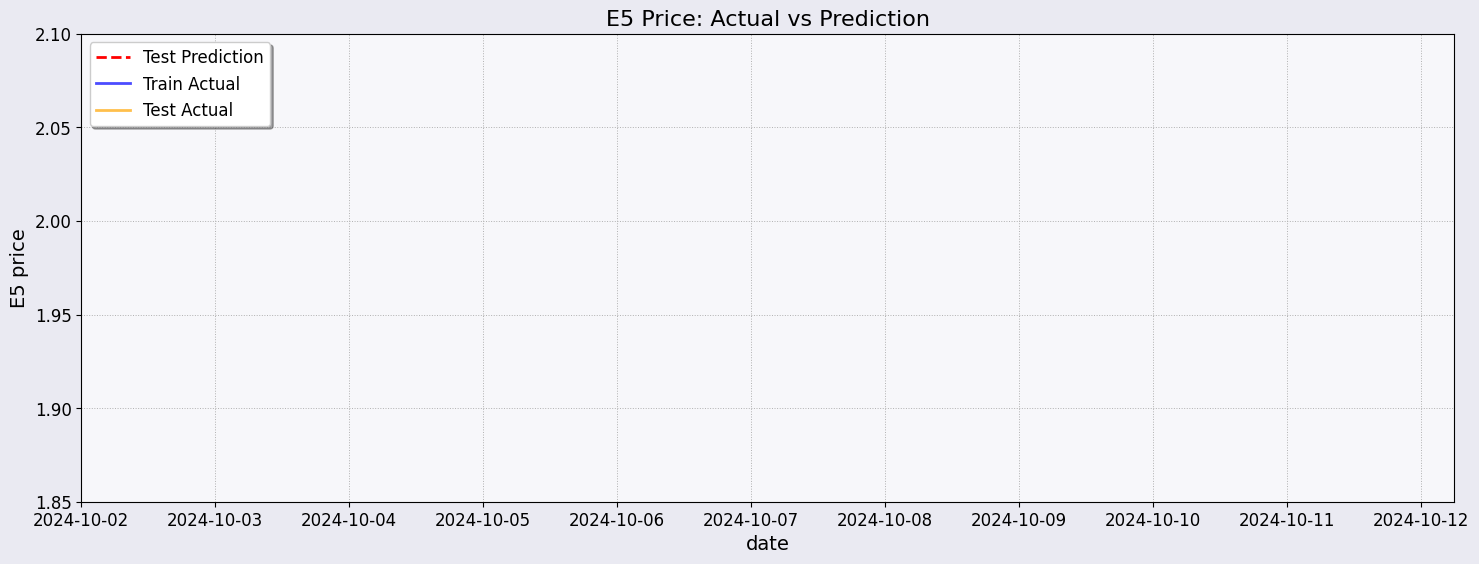

Successfully processed df05

Processing dataset: df06
1-Day MAE in cent: 3.7531
1-Day RMSE in cent: 4.2153
1-Day r2-score: -0.0098
3-Day MAE in cent: 3.6189
3-Day RMSE in cent: 4.0821
3-Day r2-score: -0.0010
7-Day MAE in cent: 3.6189
7-Day RMSE in cent: 4.0821
7-Day r2-score: -0.0010


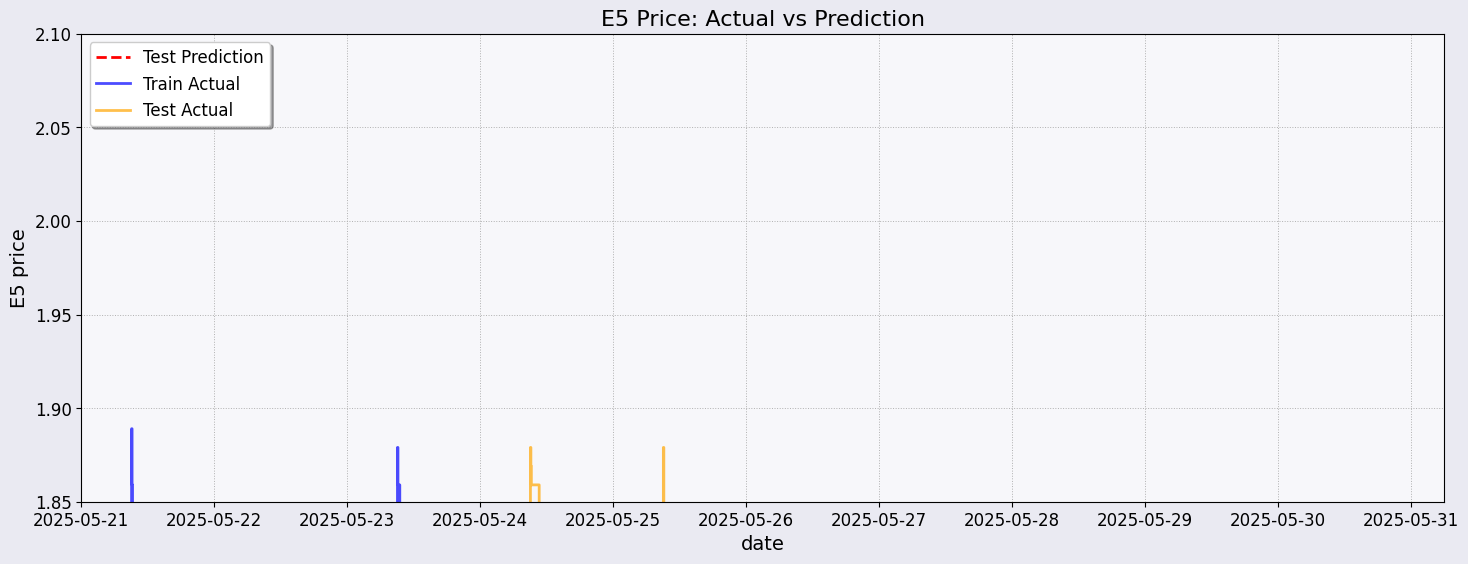

Successfully processed df06

Processing dataset: df07
1-Day MAE in cent: 2.2214
1-Day RMSE in cent: 2.8375
1-Day r2-score: -0.0262
3-Day MAE in cent: 2.4512
3-Day RMSE in cent: 3.2487
3-Day r2-score: -0.0475
7-Day MAE in cent: 2.3458
7-Day RMSE in cent: 3.0260
7-Day r2-score: -0.0204


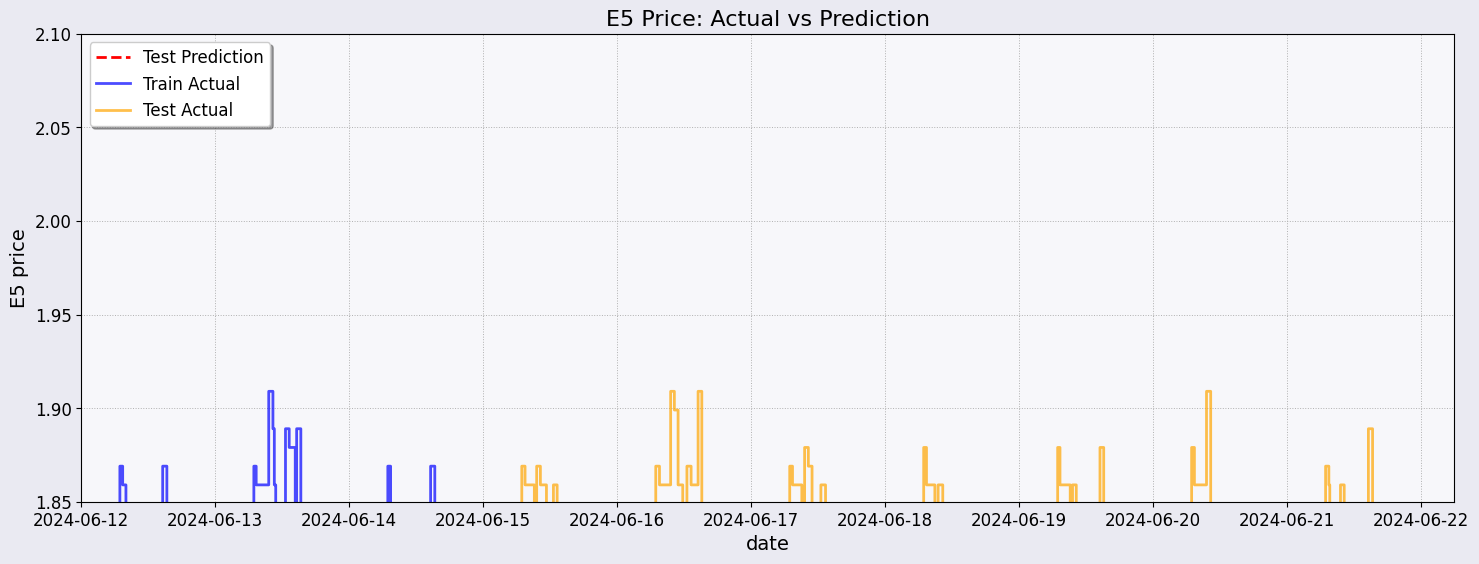

Successfully processed df07

Processing dataset: df08
1-Day MAE in cent: 1.9139
1-Day RMSE in cent: 3.0961
1-Day r2-score: -0.0712
3-Day MAE in cent: 1.8415
3-Day RMSE in cent: 3.3187
3-Day r2-score: -0.1837
7-Day MAE in cent: 2.3895
7-Day RMSE in cent: 3.9948
7-Day r2-score: -0.1942


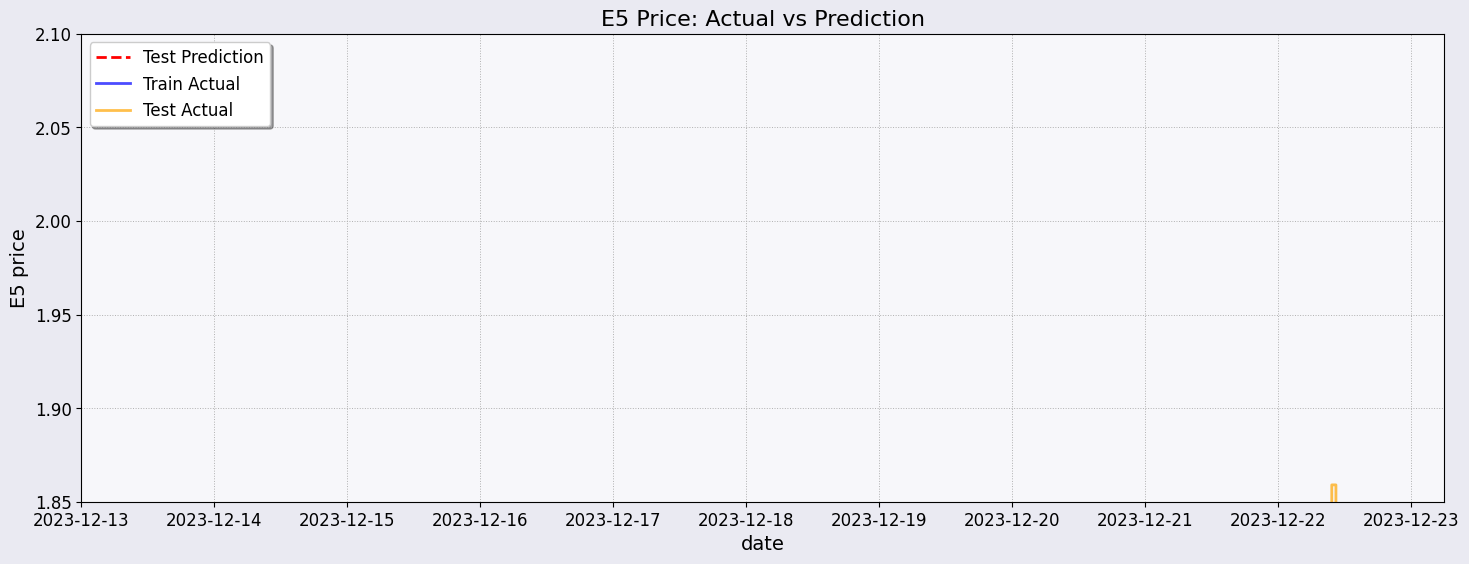

Successfully processed df08

Processing dataset: df09
1-Day MAE in cent: 2.0804
1-Day RMSE in cent: 2.8535
1-Day r2-score: -0.0059
3-Day MAE in cent: 2.2228
3-Day RMSE in cent: 2.9234
3-Day r2-score: -0.0018
7-Day MAE in cent: 2.3894
7-Day RMSE in cent: 3.0526
7-Day r2-score: -0.1461


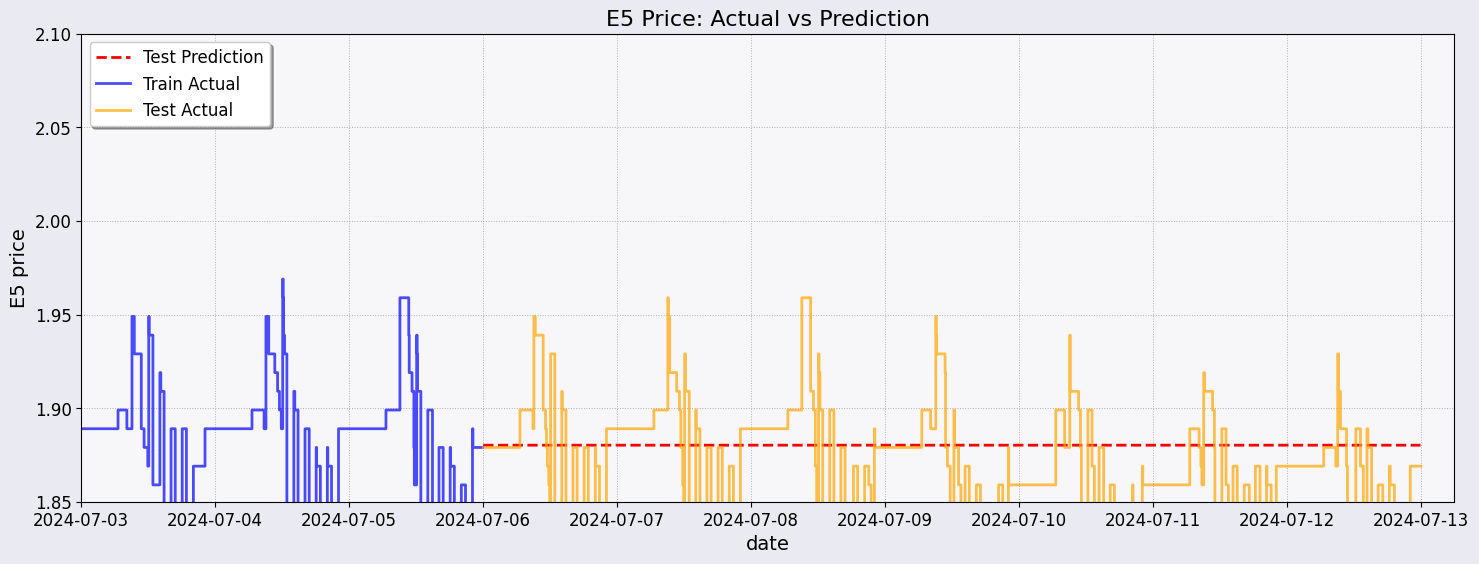

Successfully processed df09

Processing dataset: df10
1-Day MAE in cent: 2.3691
1-Day RMSE in cent: 3.0022
1-Day r2-score: -0.1790
3-Day MAE in cent: 1.9756
3-Day RMSE in cent: 2.4140
3-Day r2-score: -0.0233
7-Day MAE in cent: 2.1804
7-Day RMSE in cent: 2.5411
7-Day r2-score: -0.0027


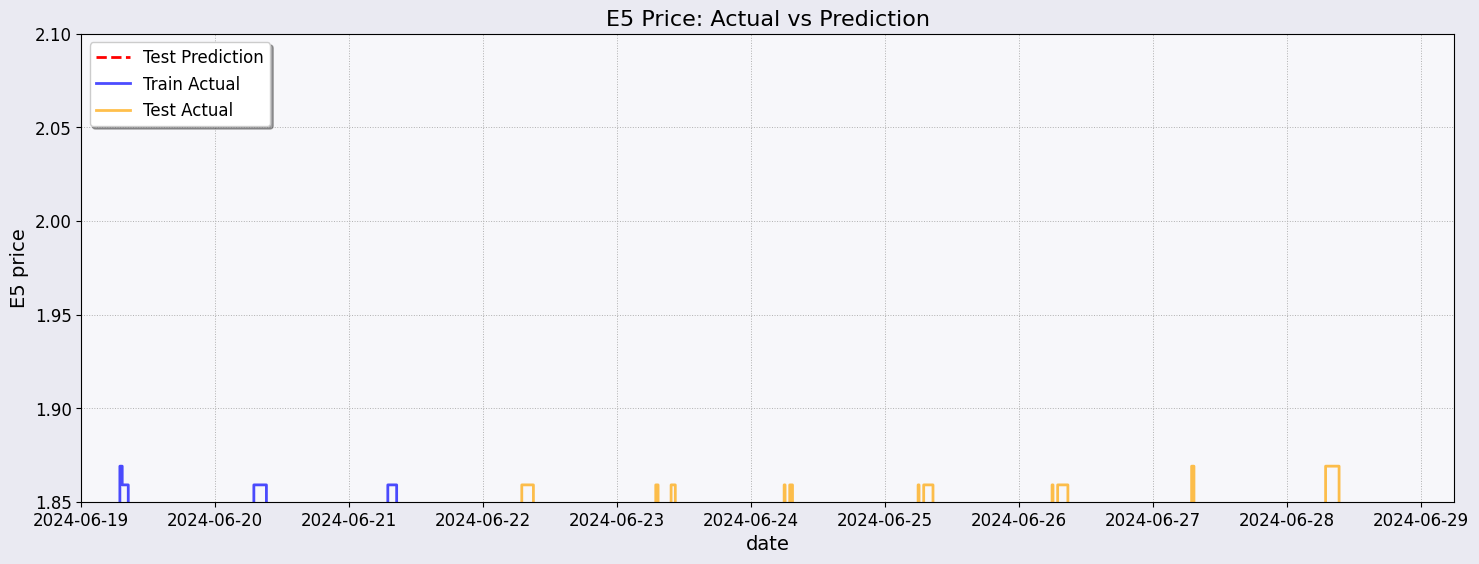

Successfully processed df10

Processing dataset: df11
1-Day MAE in cent: 3.4954
1-Day RMSE in cent: 4.1502
1-Day r2-score: -0.1902
3-Day MAE in cent: 3.0432
3-Day RMSE in cent: 3.7578
3-Day r2-score: -0.1911
7-Day MAE in cent: 3.9733
7-Day RMSE in cent: 4.6941
7-Day r2-score: -0.0000


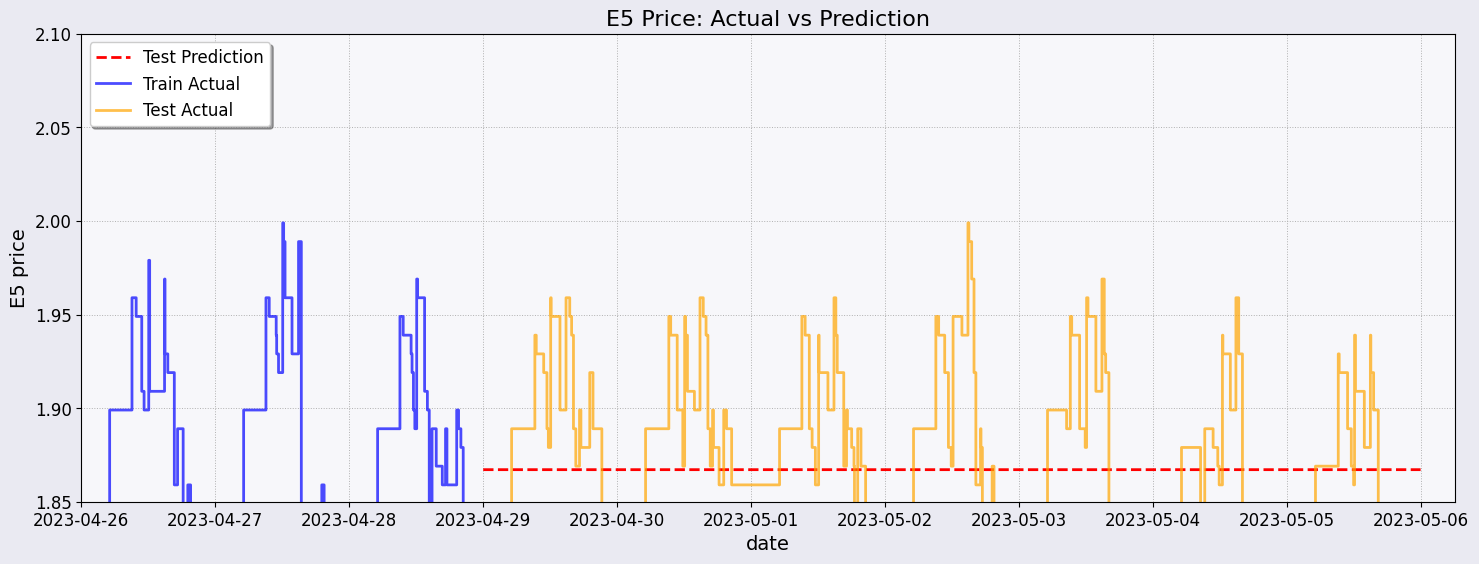

Successfully processed df11

Processing dataset: df12
1-Day MAE in cent: 3.4525
1-Day RMSE in cent: 3.8148
1-Day r2-score: -0.0447
3-Day MAE in cent: 3.3608
3-Day RMSE in cent: 3.7427
3-Day r2-score: -0.0760
7-Day MAE in cent: 3.0037
7-Day RMSE in cent: 3.4017
7-Day r2-score: -0.1225


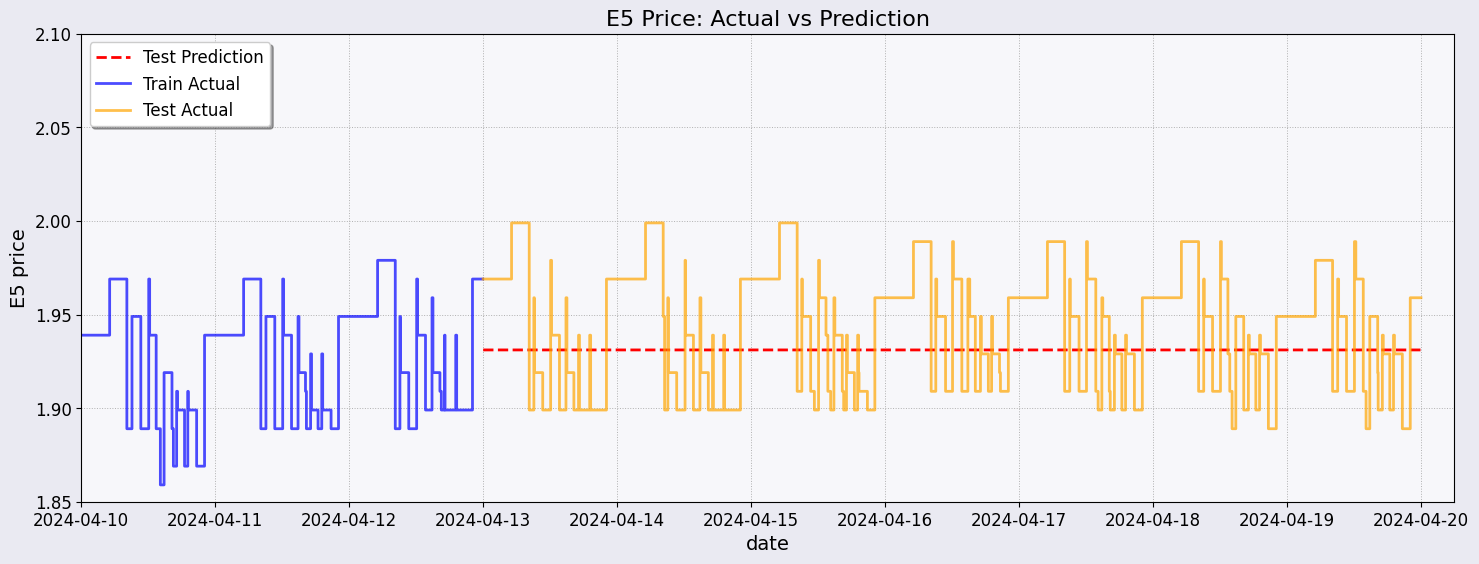

Successfully processed df12

Processing dataset: df13
1-Day MAE in cent: 2.5747
1-Day RMSE in cent: 3.4678
1-Day r2-score: -0.2528
3-Day MAE in cent: 2.4482
3-Day RMSE in cent: 3.2042
3-Day r2-score: -0.0889
7-Day MAE in cent: 2.5712
7-Day RMSE in cent: 3.4501
7-Day r2-score: -0.0547


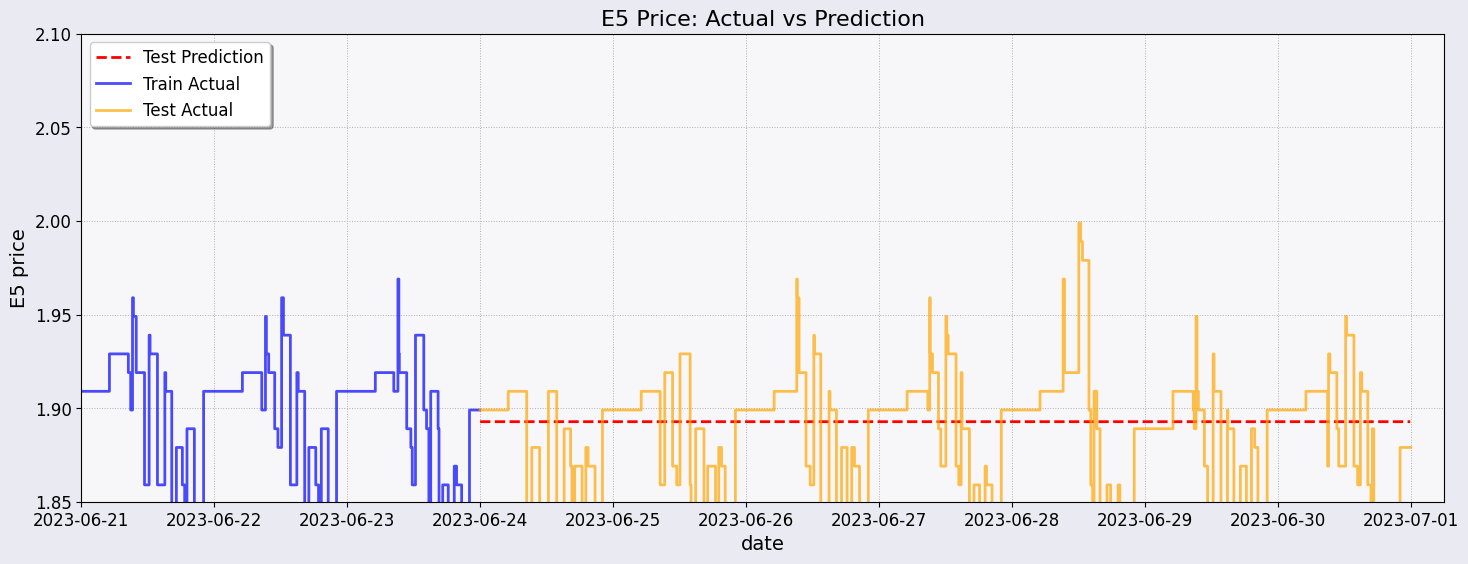

Successfully processed df13

Processing dataset: df14
1-Day MAE in cent: 3.2765
1-Day RMSE in cent: 4.5235
1-Day r2-score: -0.8527
3-Day MAE in cent: 3.4145
3-Day RMSE in cent: 4.4752
3-Day r2-score: -0.8387
7-Day MAE in cent: 3.9928
7-Day RMSE in cent: 5.1988
7-Day r2-score: -1.0362


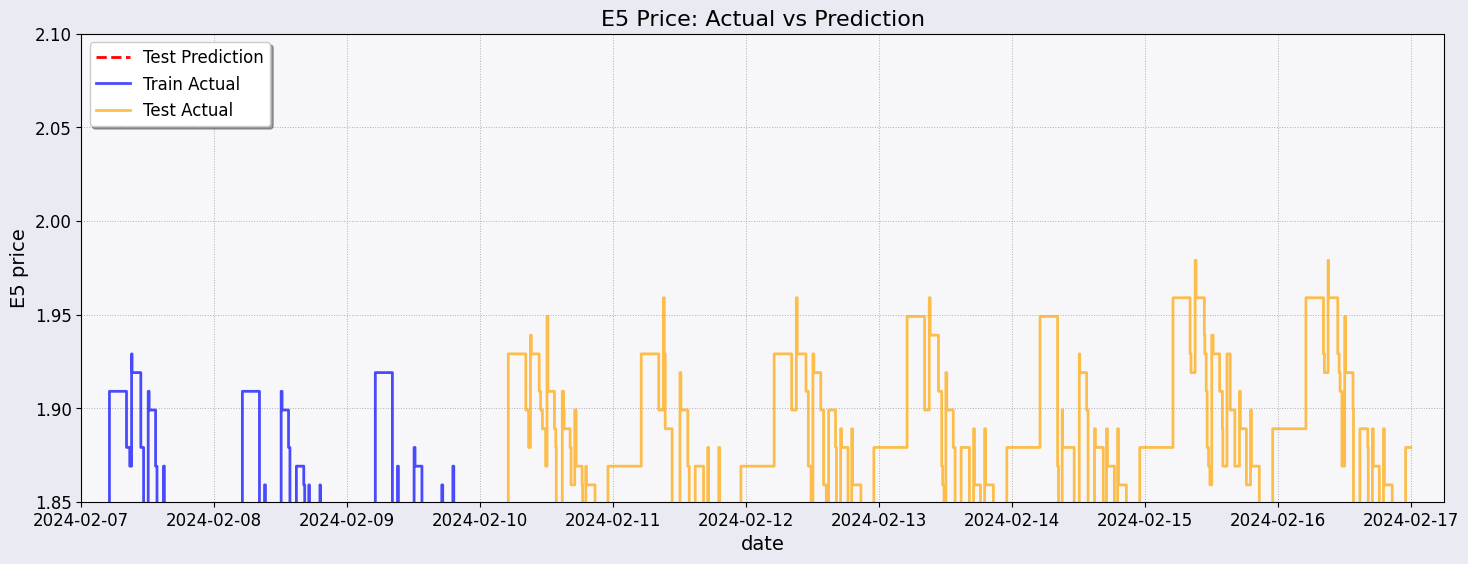

Successfully processed df14

Processing dataset: df15
1-Day MAE in cent: 2.3539
1-Day RMSE in cent: 3.6843
1-Day r2-score: -0.0358
3-Day MAE in cent: 3.0933
3-Day RMSE in cent: 4.7393
3-Day r2-score: -0.1324
7-Day MAE in cent: 2.8796
7-Day RMSE in cent: 4.3557
7-Day r2-score: -0.0853


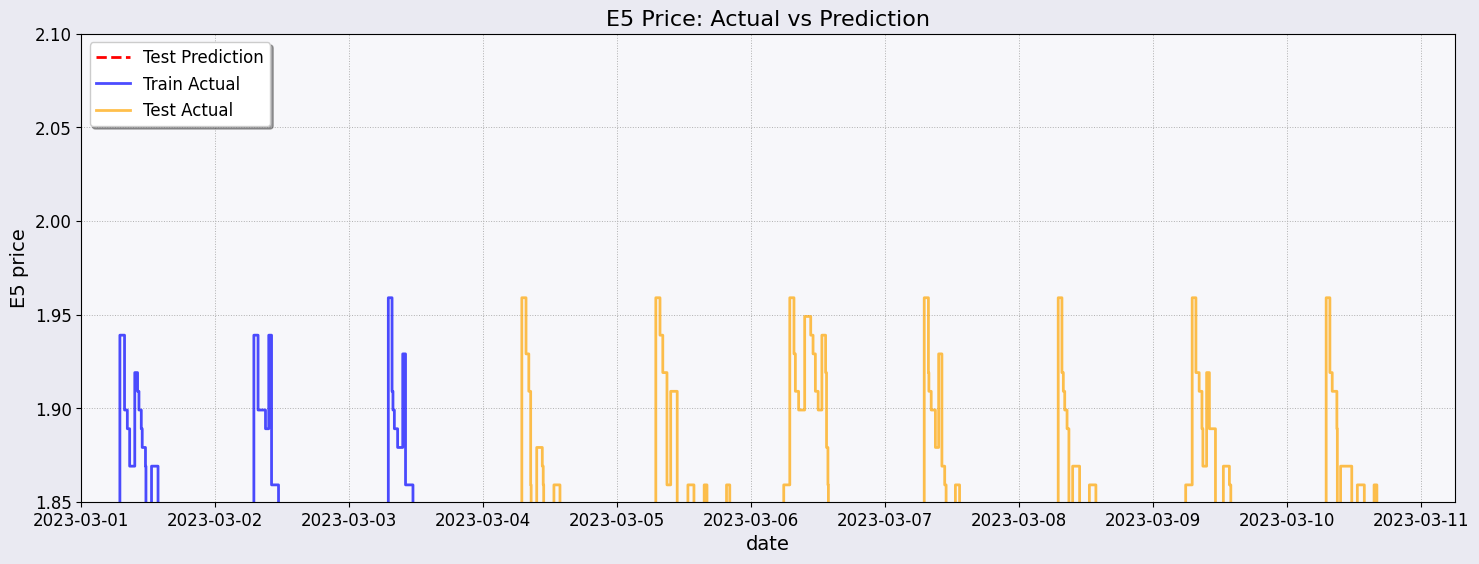

Successfully processed df15

Processing dataset: df16
1-Day MAE in cent: 3.0774
1-Day RMSE in cent: 3.4287
1-Day r2-score: -0.2299
3-Day MAE in cent: 3.0968
3-Day RMSE in cent: 3.4837
3-Day r2-score: -0.1674
7-Day MAE in cent: 2.8917
7-Day RMSE in cent: 3.3734
7-Day r2-score: -0.0785


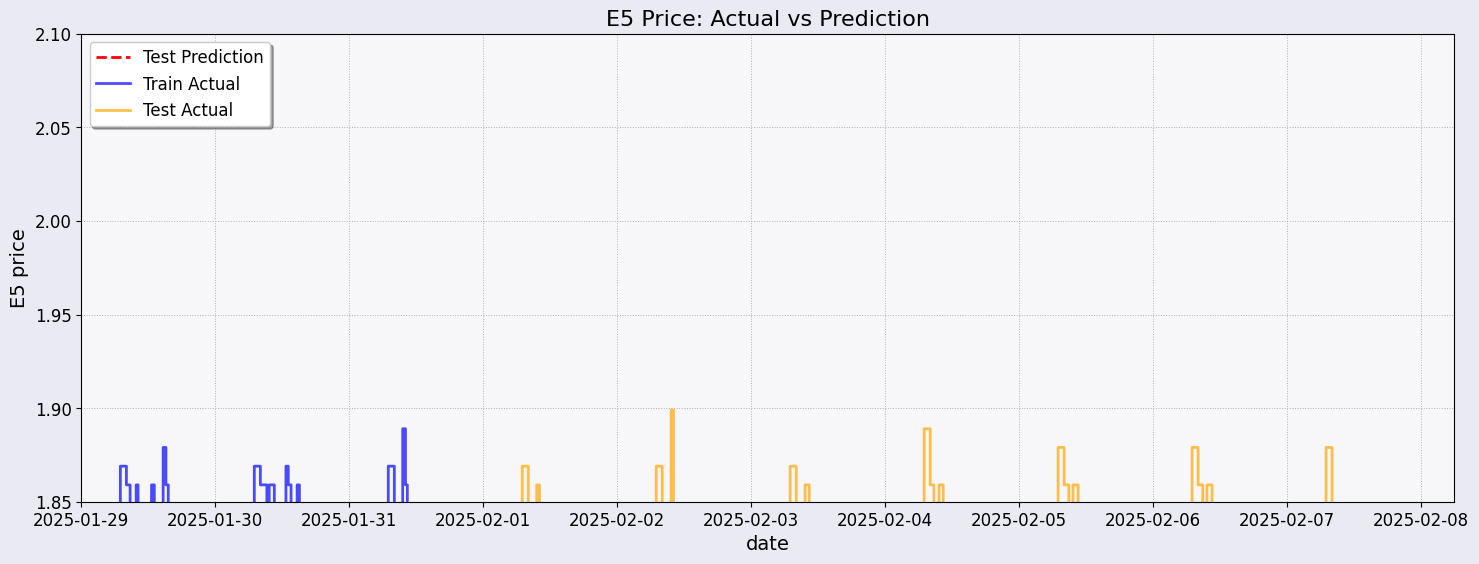

Successfully processed df16

Processing dataset: df17
1-Day MAE in cent: 3.4718
1-Day RMSE in cent: 4.4618
1-Day r2-score: -0.0057
3-Day MAE in cent: 3.5027
3-Day RMSE in cent: 4.4342
3-Day r2-score: -0.0018
7-Day MAE in cent: 3.4606
7-Day RMSE in cent: 4.4988
7-Day r2-score: -0.0064


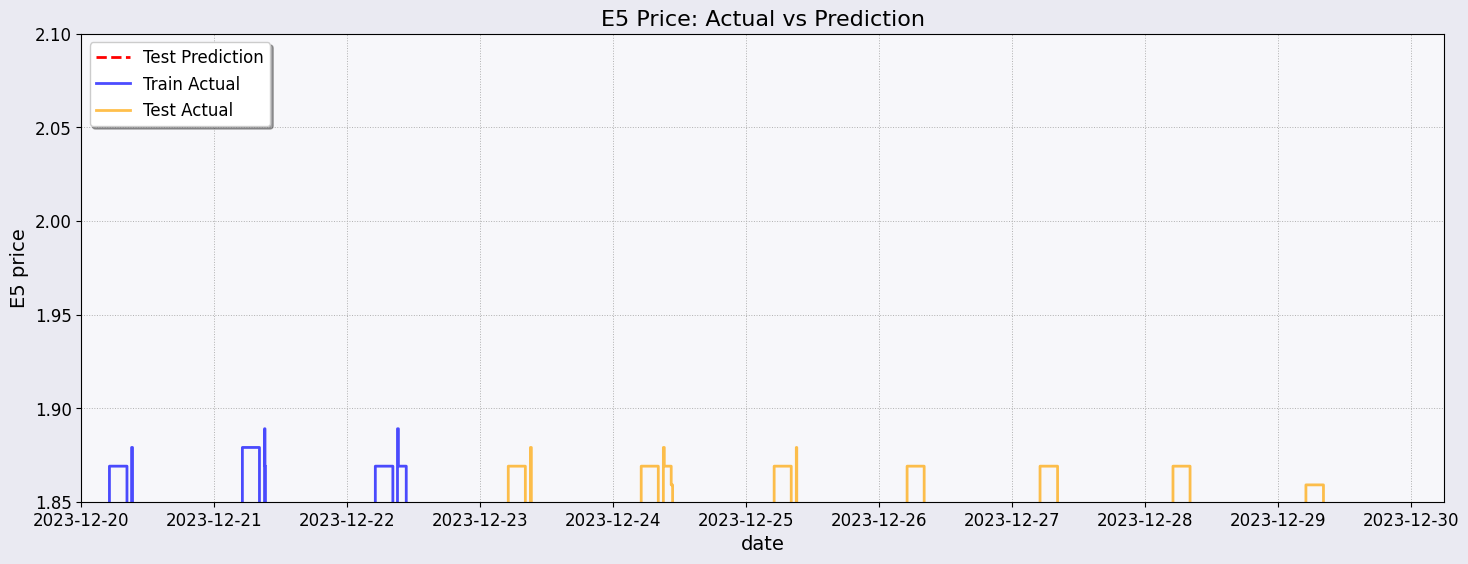

Successfully processed df17

Processing dataset: df18
1-Day MAE in cent: 2.3074
1-Day RMSE in cent: 3.2876
1-Day r2-score: -0.0483
3-Day MAE in cent: 2.5948
3-Day RMSE in cent: 3.5514
3-Day r2-score: -0.1286
7-Day MAE in cent: 2.8043
7-Day RMSE in cent: 3.8717
7-Day r2-score: -0.1236


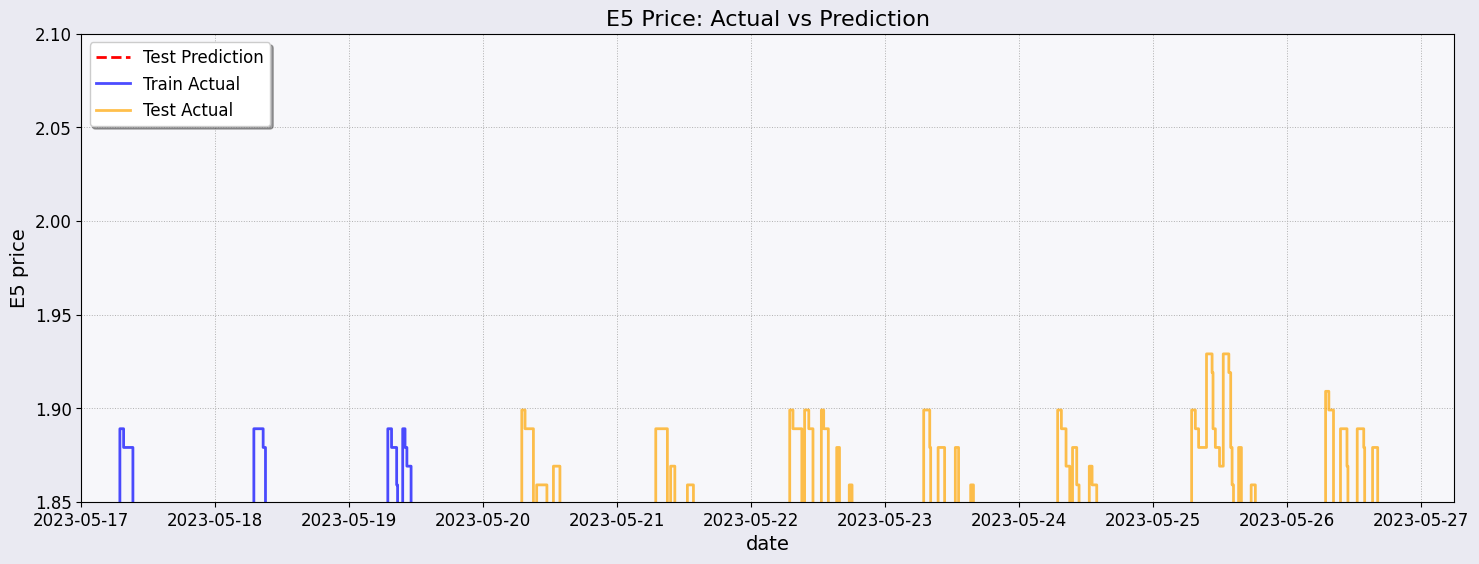

Successfully processed df18

Processing dataset: df19
1-Day MAE in cent: 0.5720
1-Day RMSE in cent: 0.5980
1-Day r2-score: -0.6747
3-Day MAE in cent: 0.6497
3-Day RMSE in cent: 0.6598
3-Day r2-score: -3.7110
7-Day MAE in cent: 0.6531
7-Day RMSE in cent: 0.7264
7-Day r2-score: -0.0102


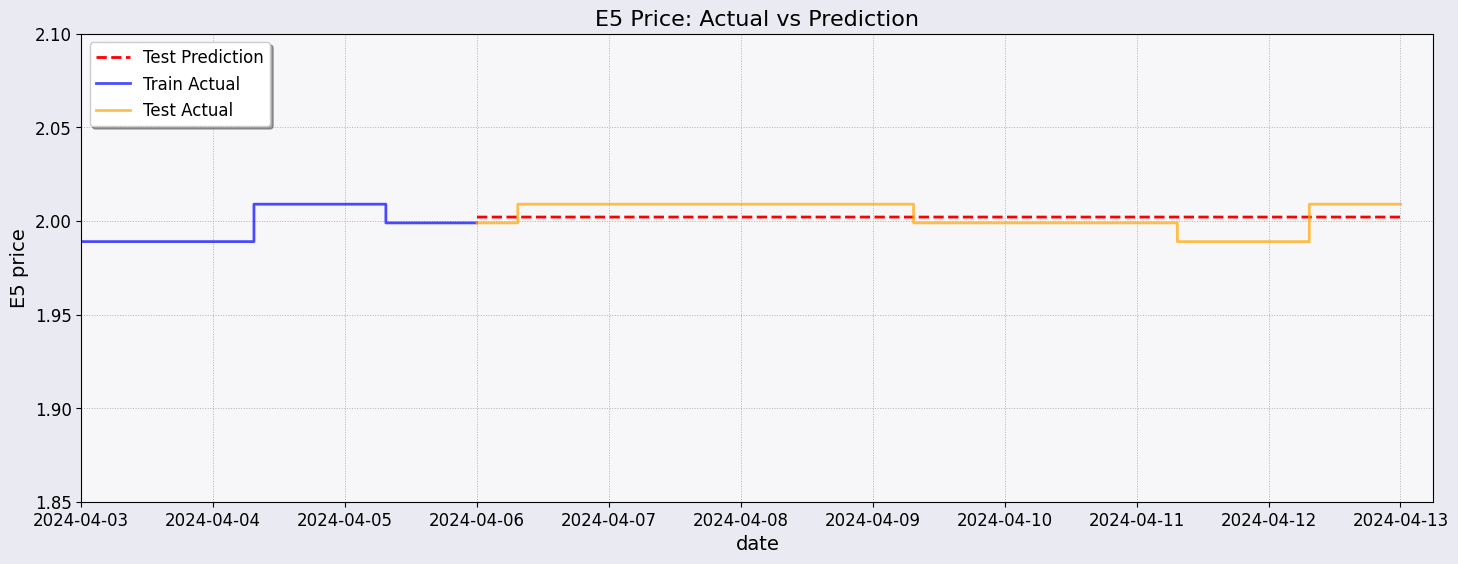

Successfully processed df19

Processing dataset: df20
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 0.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 0.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 0.0000


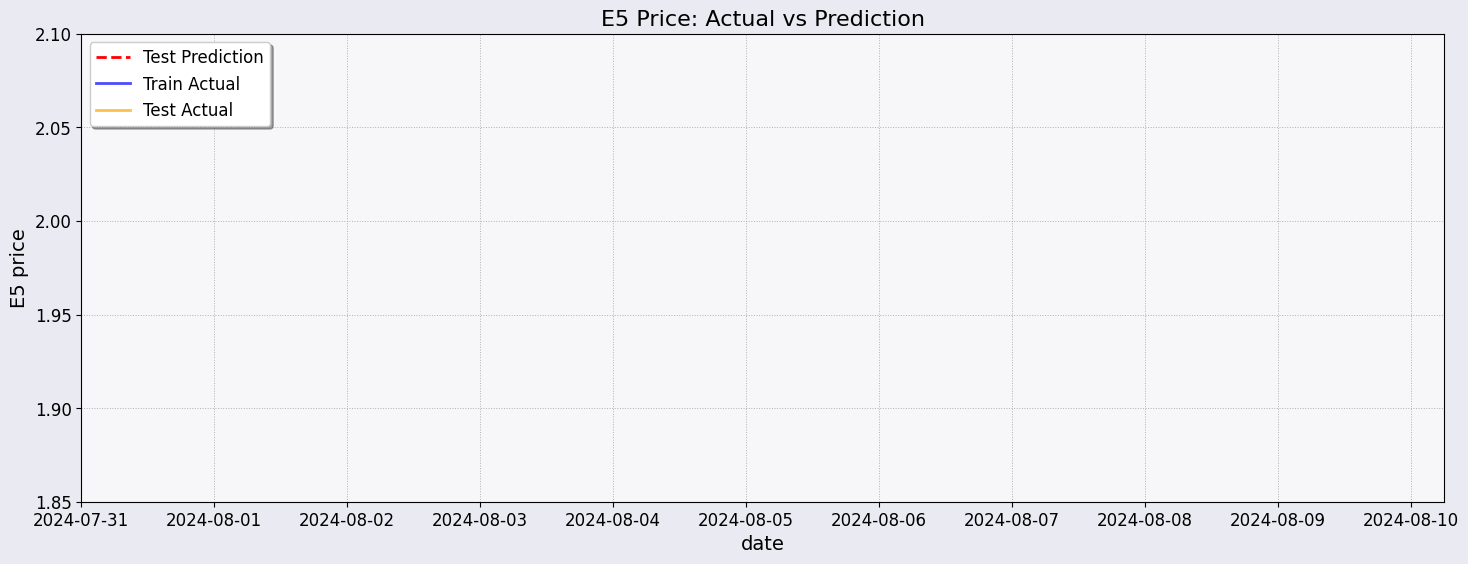

Successfully processed df20

Processing dataset: df21
1-Day MAE in cent: 1.5829
1-Day RMSE in cent: 2.1170
1-Day r2-score: -0.0001
3-Day MAE in cent: 1.5572
3-Day RMSE in cent: 1.9667
3-Day r2-score: -0.0014
7-Day MAE in cent: 1.5627
7-Day RMSE in cent: 2.0182
7-Day r2-score: -0.0002


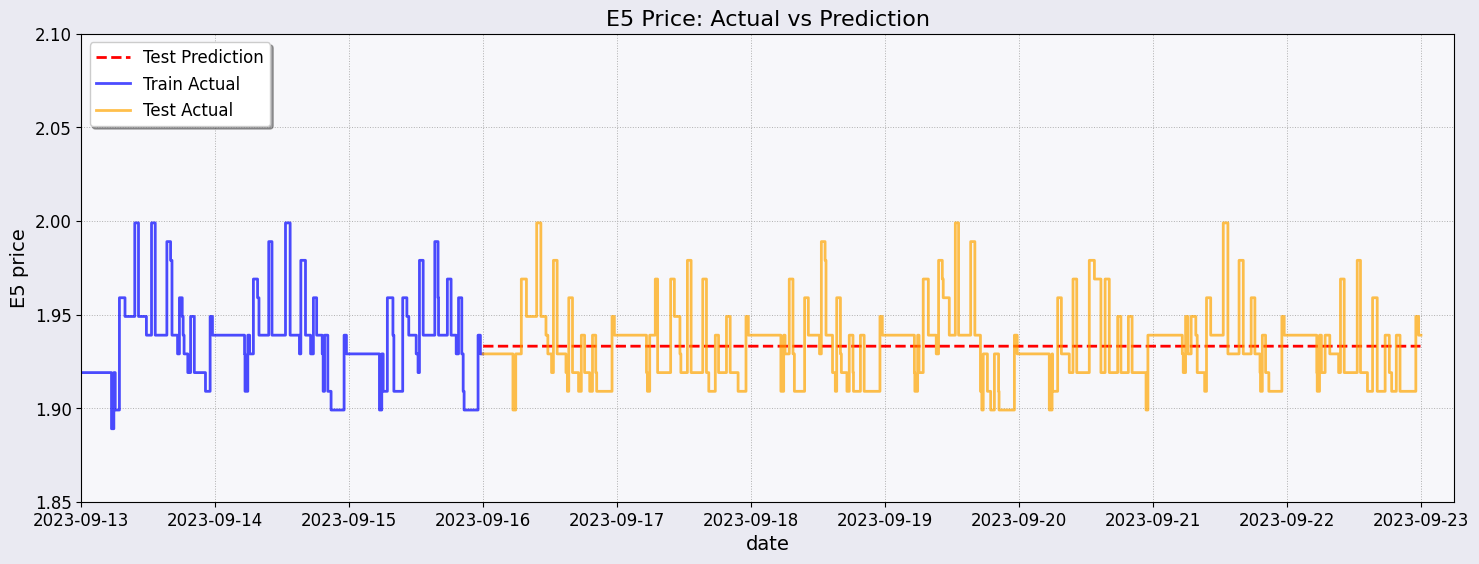

Successfully processed df21

Processing dataset: df22
1-Day MAE in cent: 2.2149
1-Day RMSE in cent: 2.8382
1-Day r2-score: -0.2758
3-Day MAE in cent: 2.4064
3-Day RMSE in cent: 3.1132
3-Day r2-score: -0.2750
7-Day MAE in cent: 2.6461
7-Day RMSE in cent: 3.3576
7-Day r2-score: -0.2456


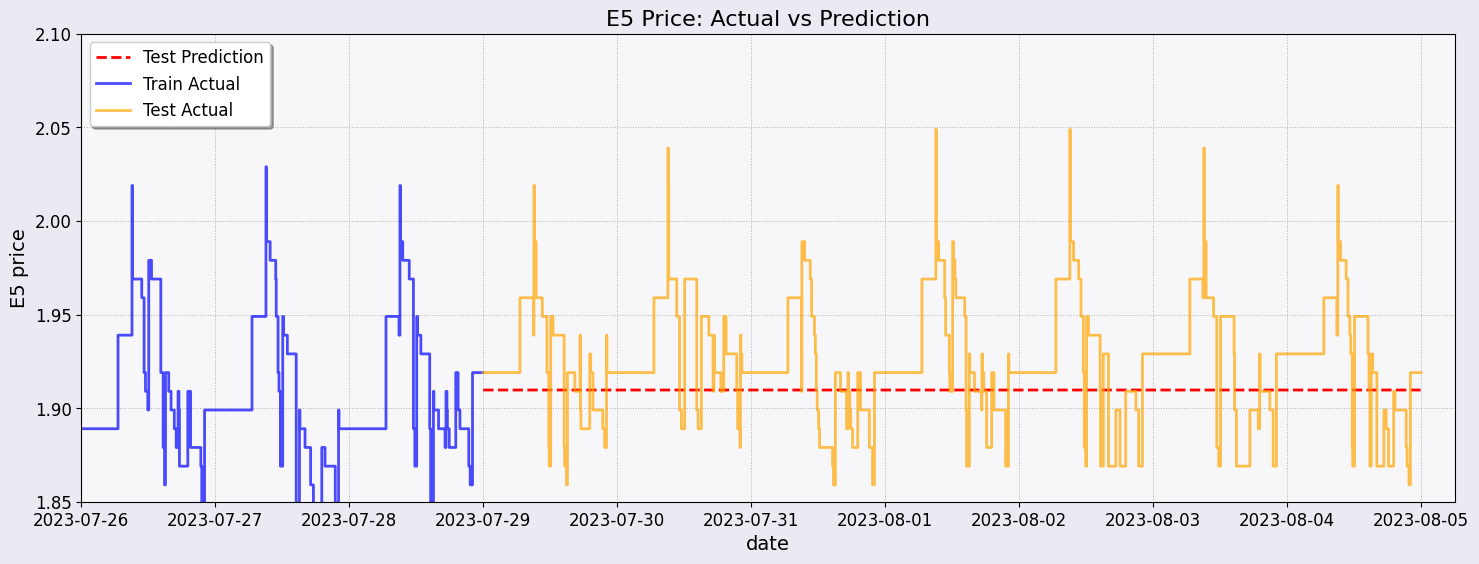

Successfully processed df22

Processing dataset: df23
1-Day MAE in cent: 2.6953
1-Day RMSE in cent: 3.2066
1-Day r2-score: -0.1260
3-Day MAE in cent: 2.5004
3-Day RMSE in cent: 3.0245
3-Day r2-score: -0.0874
7-Day MAE in cent: 2.4615
7-Day RMSE in cent: 3.0371
7-Day r2-score: -0.0906


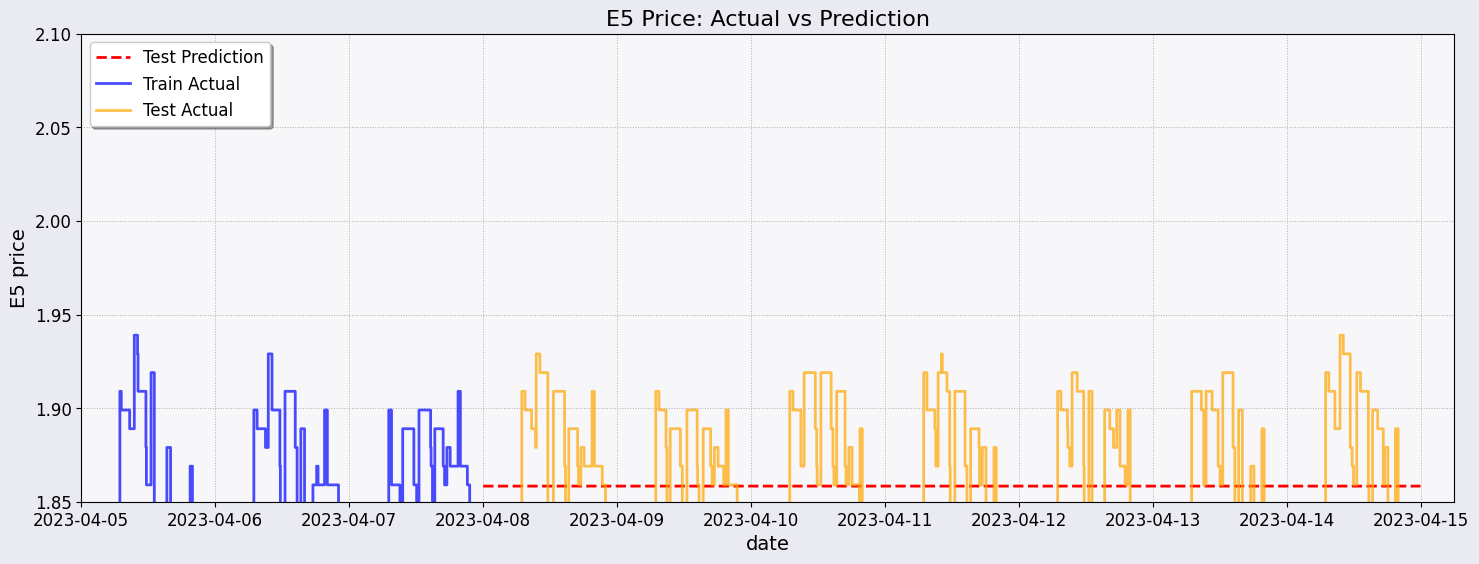

Successfully processed df23

Processing dataset: df24
1-Day MAE in cent: 4.4465
1-Day RMSE in cent: 4.8072
1-Day r2-score: -0.4281
3-Day MAE in cent: 4.0915
3-Day RMSE in cent: 4.5772
3-Day r2-score: -0.0679
7-Day MAE in cent: 5.3454
7-Day RMSE in cent: 5.9474
7-Day r2-score: -0.3547


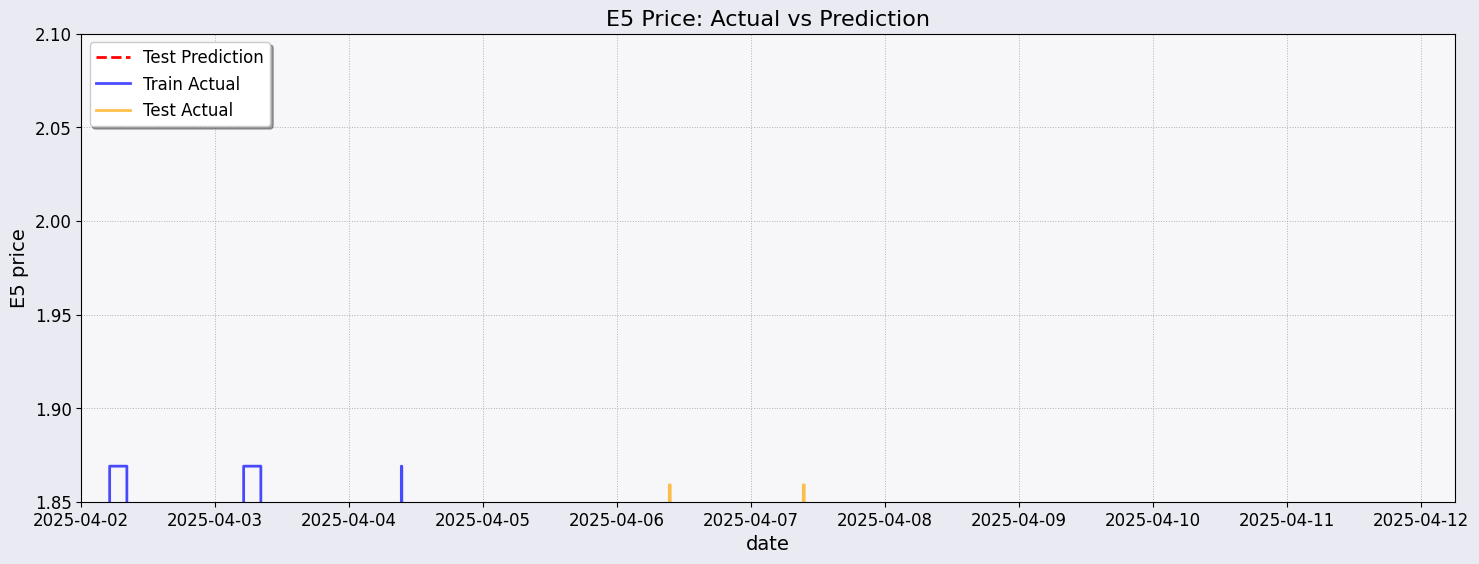

Successfully processed df24

Processing dataset: df25
1-Day MAE in cent: 2.3435
1-Day RMSE in cent: 3.0110
1-Day r2-score: -0.1591
3-Day MAE in cent: 2.6861
3-Day RMSE in cent: 3.3656
3-Day r2-score: -0.2188
7-Day MAE in cent: 2.6004
7-Day RMSE in cent: 3.3394
7-Day r2-score: -0.2443


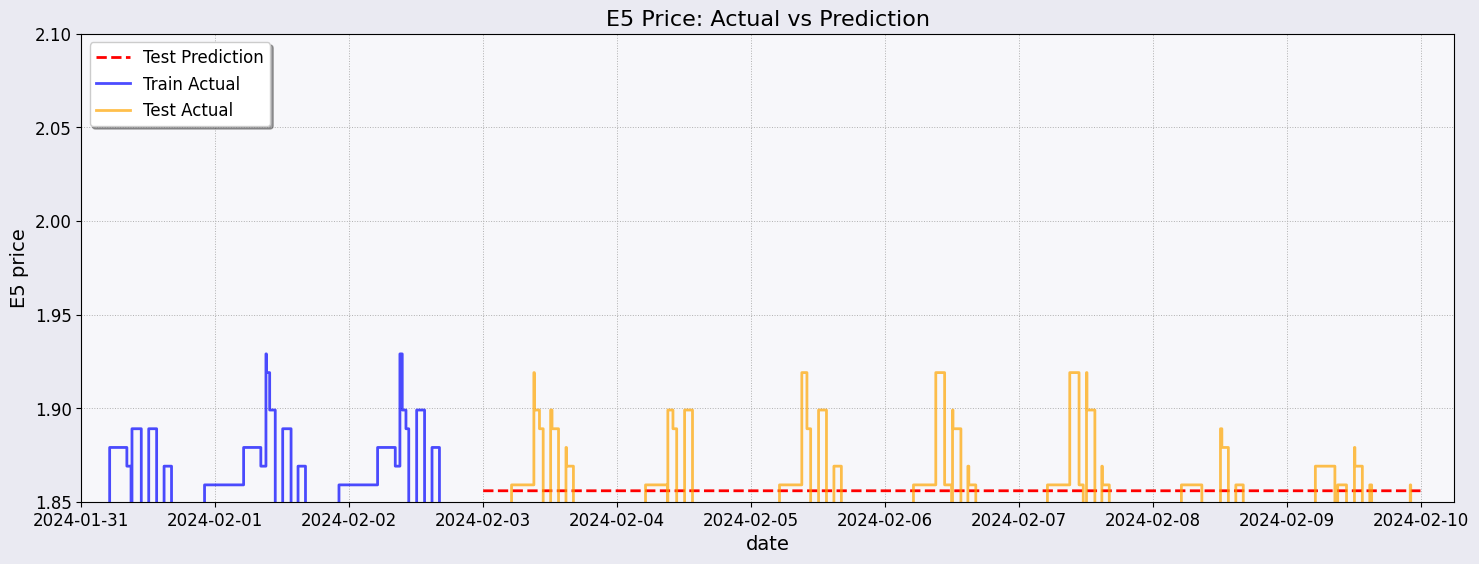

Successfully processed df25

Processing dataset: df26
1-Day MAE in cent: 3.7345
1-Day RMSE in cent: 4.8753
1-Day r2-score: -0.2178
3-Day MAE in cent: 3.6554
3-Day RMSE in cent: 4.7530
3-Day r2-score: -0.1420
7-Day MAE in cent: 3.5139
7-Day RMSE in cent: 4.5822
7-Day r2-score: -0.1226


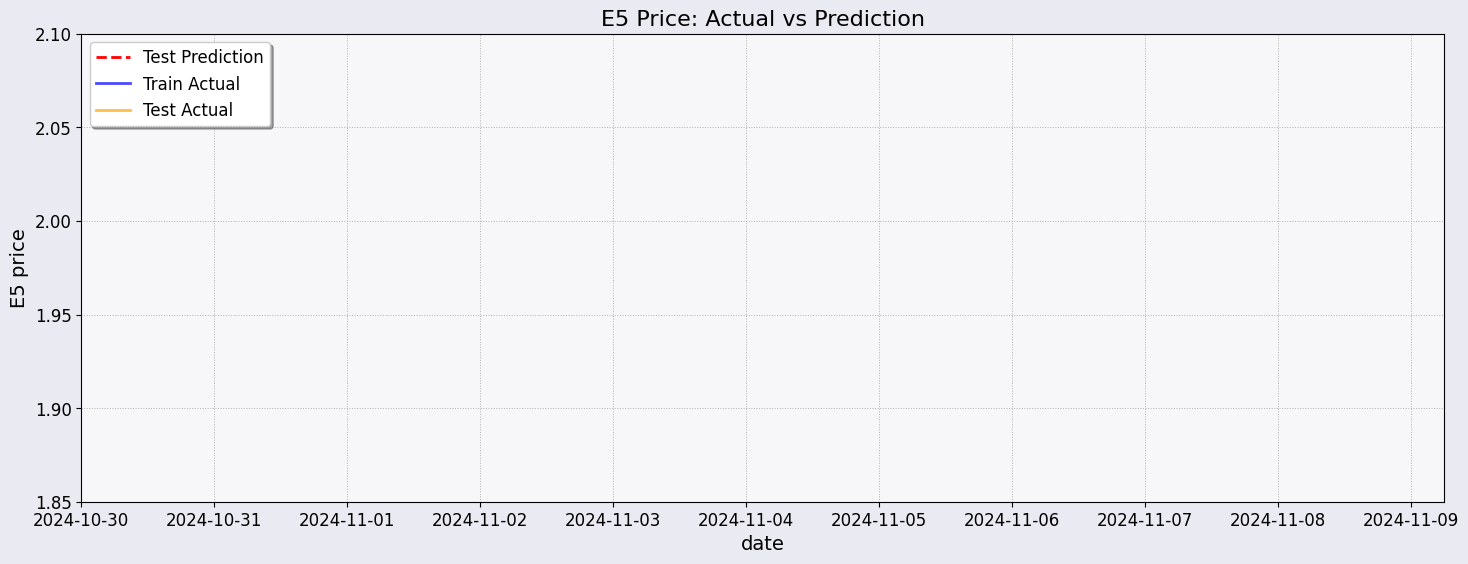

Successfully processed df26

Processing dataset: df27
1-Day MAE in cent: 2.9012
1-Day RMSE in cent: 3.4849
1-Day r2-score: -0.0059
3-Day MAE in cent: 3.0971
3-Day RMSE in cent: 3.8304
3-Day r2-score: -0.0050
7-Day MAE in cent: 3.8586
7-Day RMSE in cent: 4.5185
7-Day r2-score: -0.0002


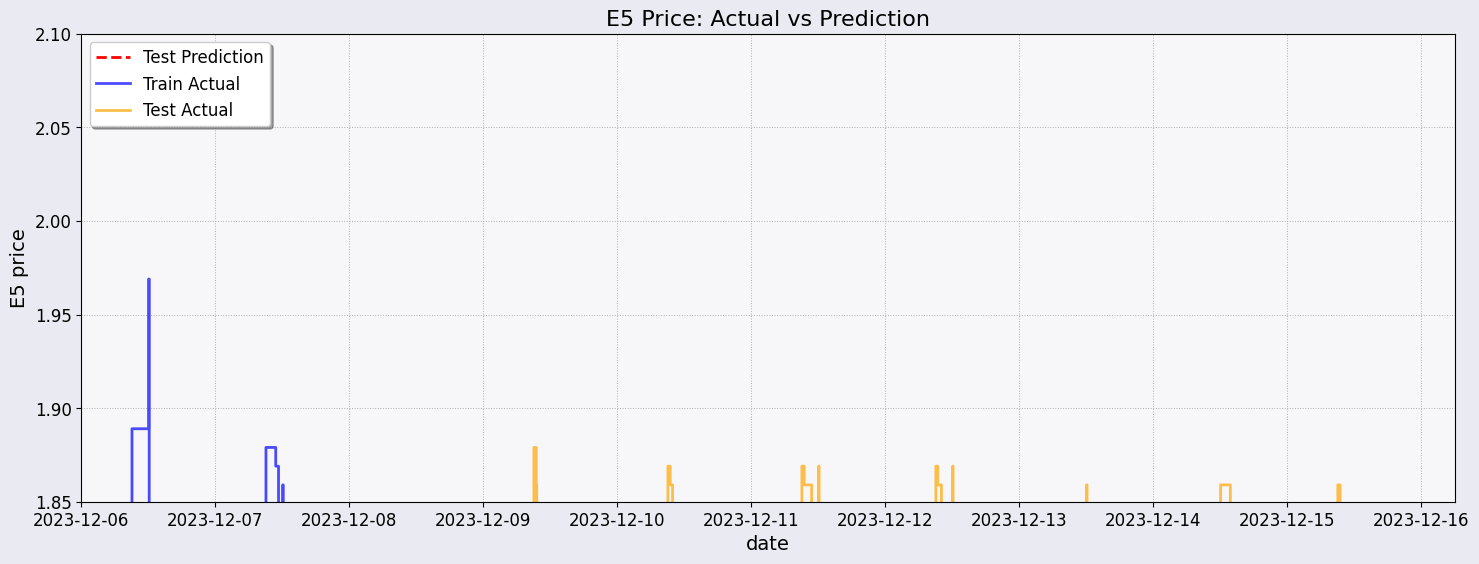

Successfully processed df27

Processing dataset: df28
1-Day MAE in cent: 2.4057
1-Day RMSE in cent: 3.2145
1-Day r2-score: -0.0182
3-Day MAE in cent: 2.2583
3-Day RMSE in cent: 3.1826
3-Day r2-score: -0.0029
7-Day MAE in cent: 3.1824
7-Day RMSE in cent: 3.8950
7-Day r2-score: -0.0748


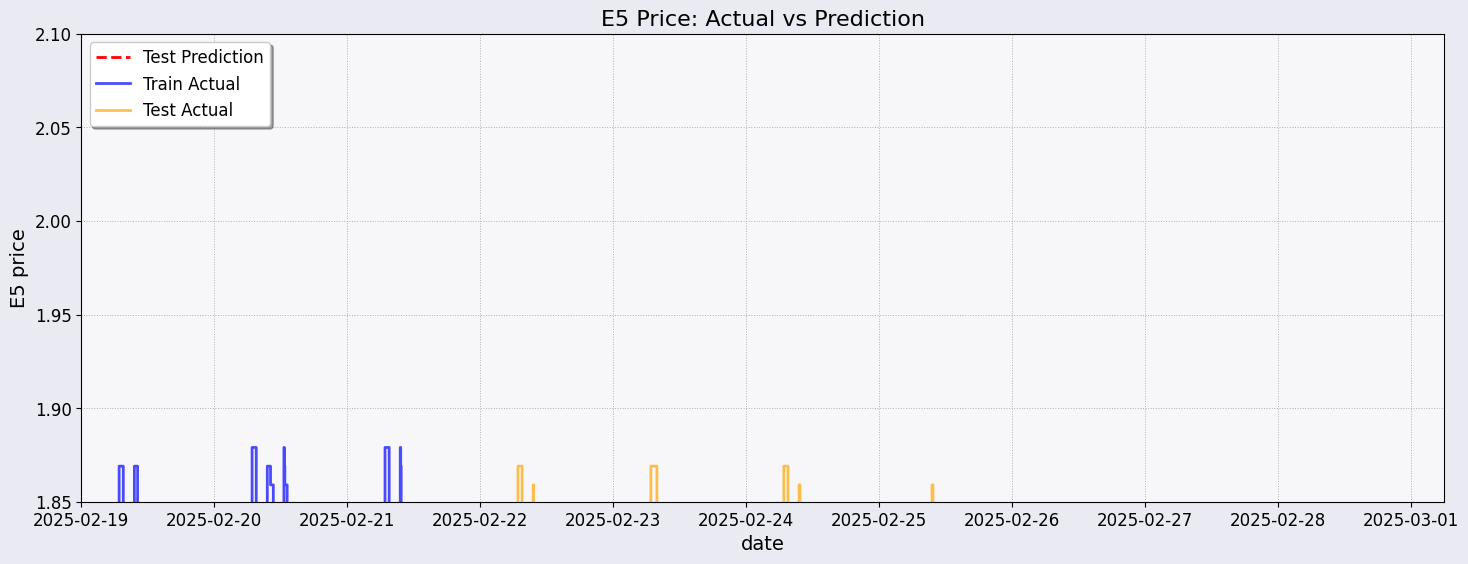

Successfully processed df28

Processing dataset: df29
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 0.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 0.8889
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 0.8889


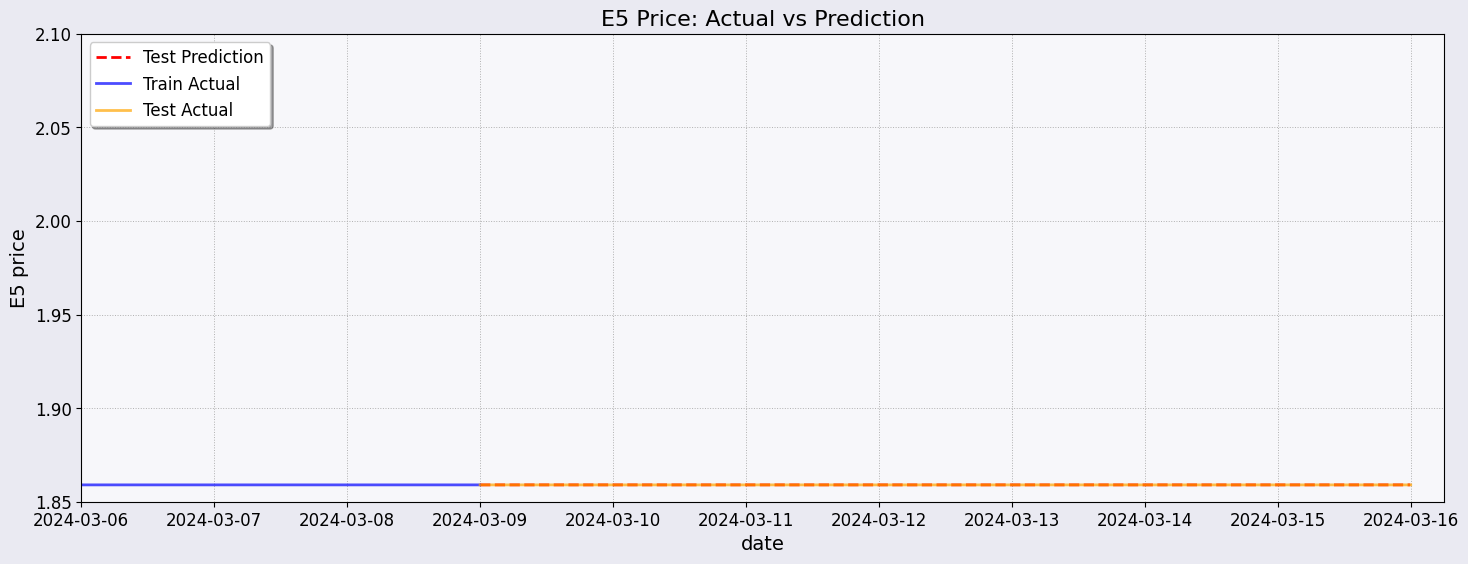

Successfully processed df29

Processing dataset: df30
1-Day MAE in cent: 2.0828
1-Day RMSE in cent: 2.7628
1-Day r2-score: -0.0027
3-Day MAE in cent: 2.4919
3-Day RMSE in cent: 3.0992
3-Day r2-score: -0.1138
7-Day MAE in cent: 3.1291
7-Day RMSE in cent: 4.1223
7-Day r2-score: -0.4062


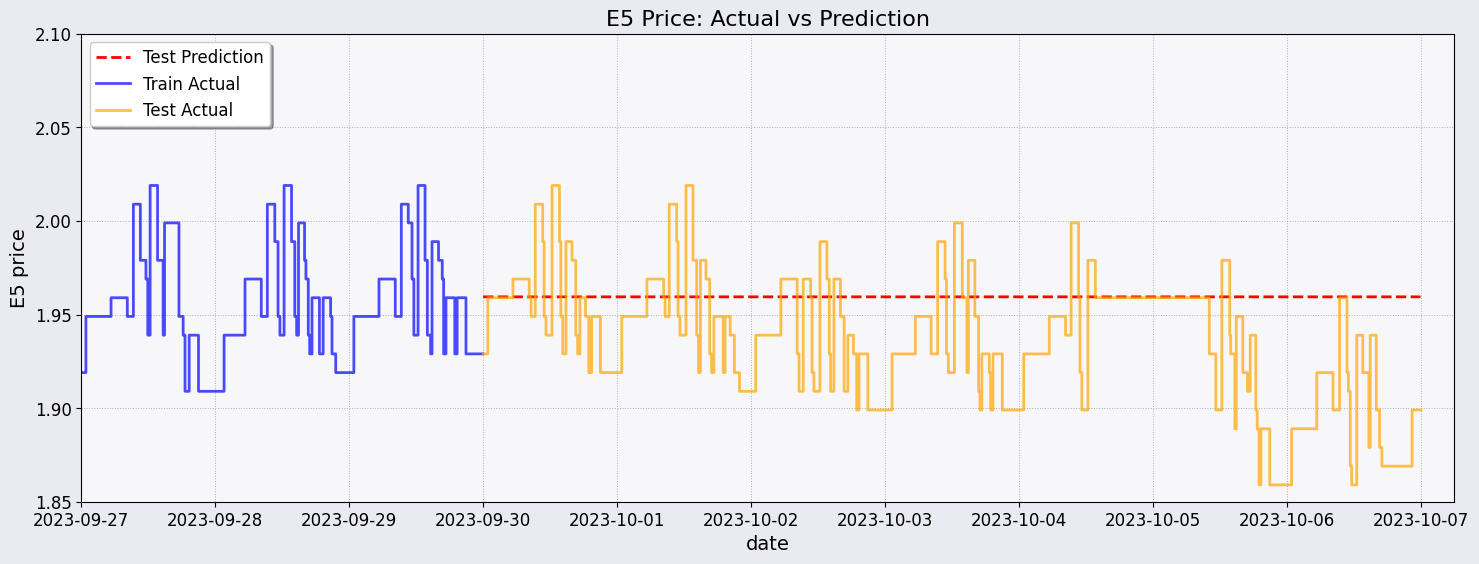

Successfully processed df30

=== Error Summary ===
All datasets processed successfully!


In [16]:
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")

    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_baseline_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['date'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=sampling_rate)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=sampling_rate)

            # model and forecast
            forecast = baseline_model(df_train, 'date', 'e5', forecast_days*1440/sampling_rate, (sampling_rate,"minutes"))

            # plotting
            train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25))

            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                df_train, 
                df_test, 
                None, 
                forecast, 
                forecast, 
                train_dates_plot, 
                test_dates_plot,
                train_dates_plot,
                test_dates_plot
                )
            mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "rmse_1_day": rmse_1_day,
            "rmse_3_day": rmse_3_day,
            "rmse_7_day": rmse_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })
            print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)

        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

In [17]:
mlflow.end_run()

In [18]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
